## Introduction to Generative Adversarial Networks 

In [1]:
from IPython.display import Image
%matplotlib inline
import torch

### General Concept of GANs

#### Use generator to generate images that discriminated by discriminator
* generator generate images, the discriminator is then used to judge if the image is real or fake
* discriminator is trained by both real and generated images as a binary classifier so that i can tell the difference between real and fake images
* train the generator so that it can generate images that the discriminator can not tell the difference between the generated and real images

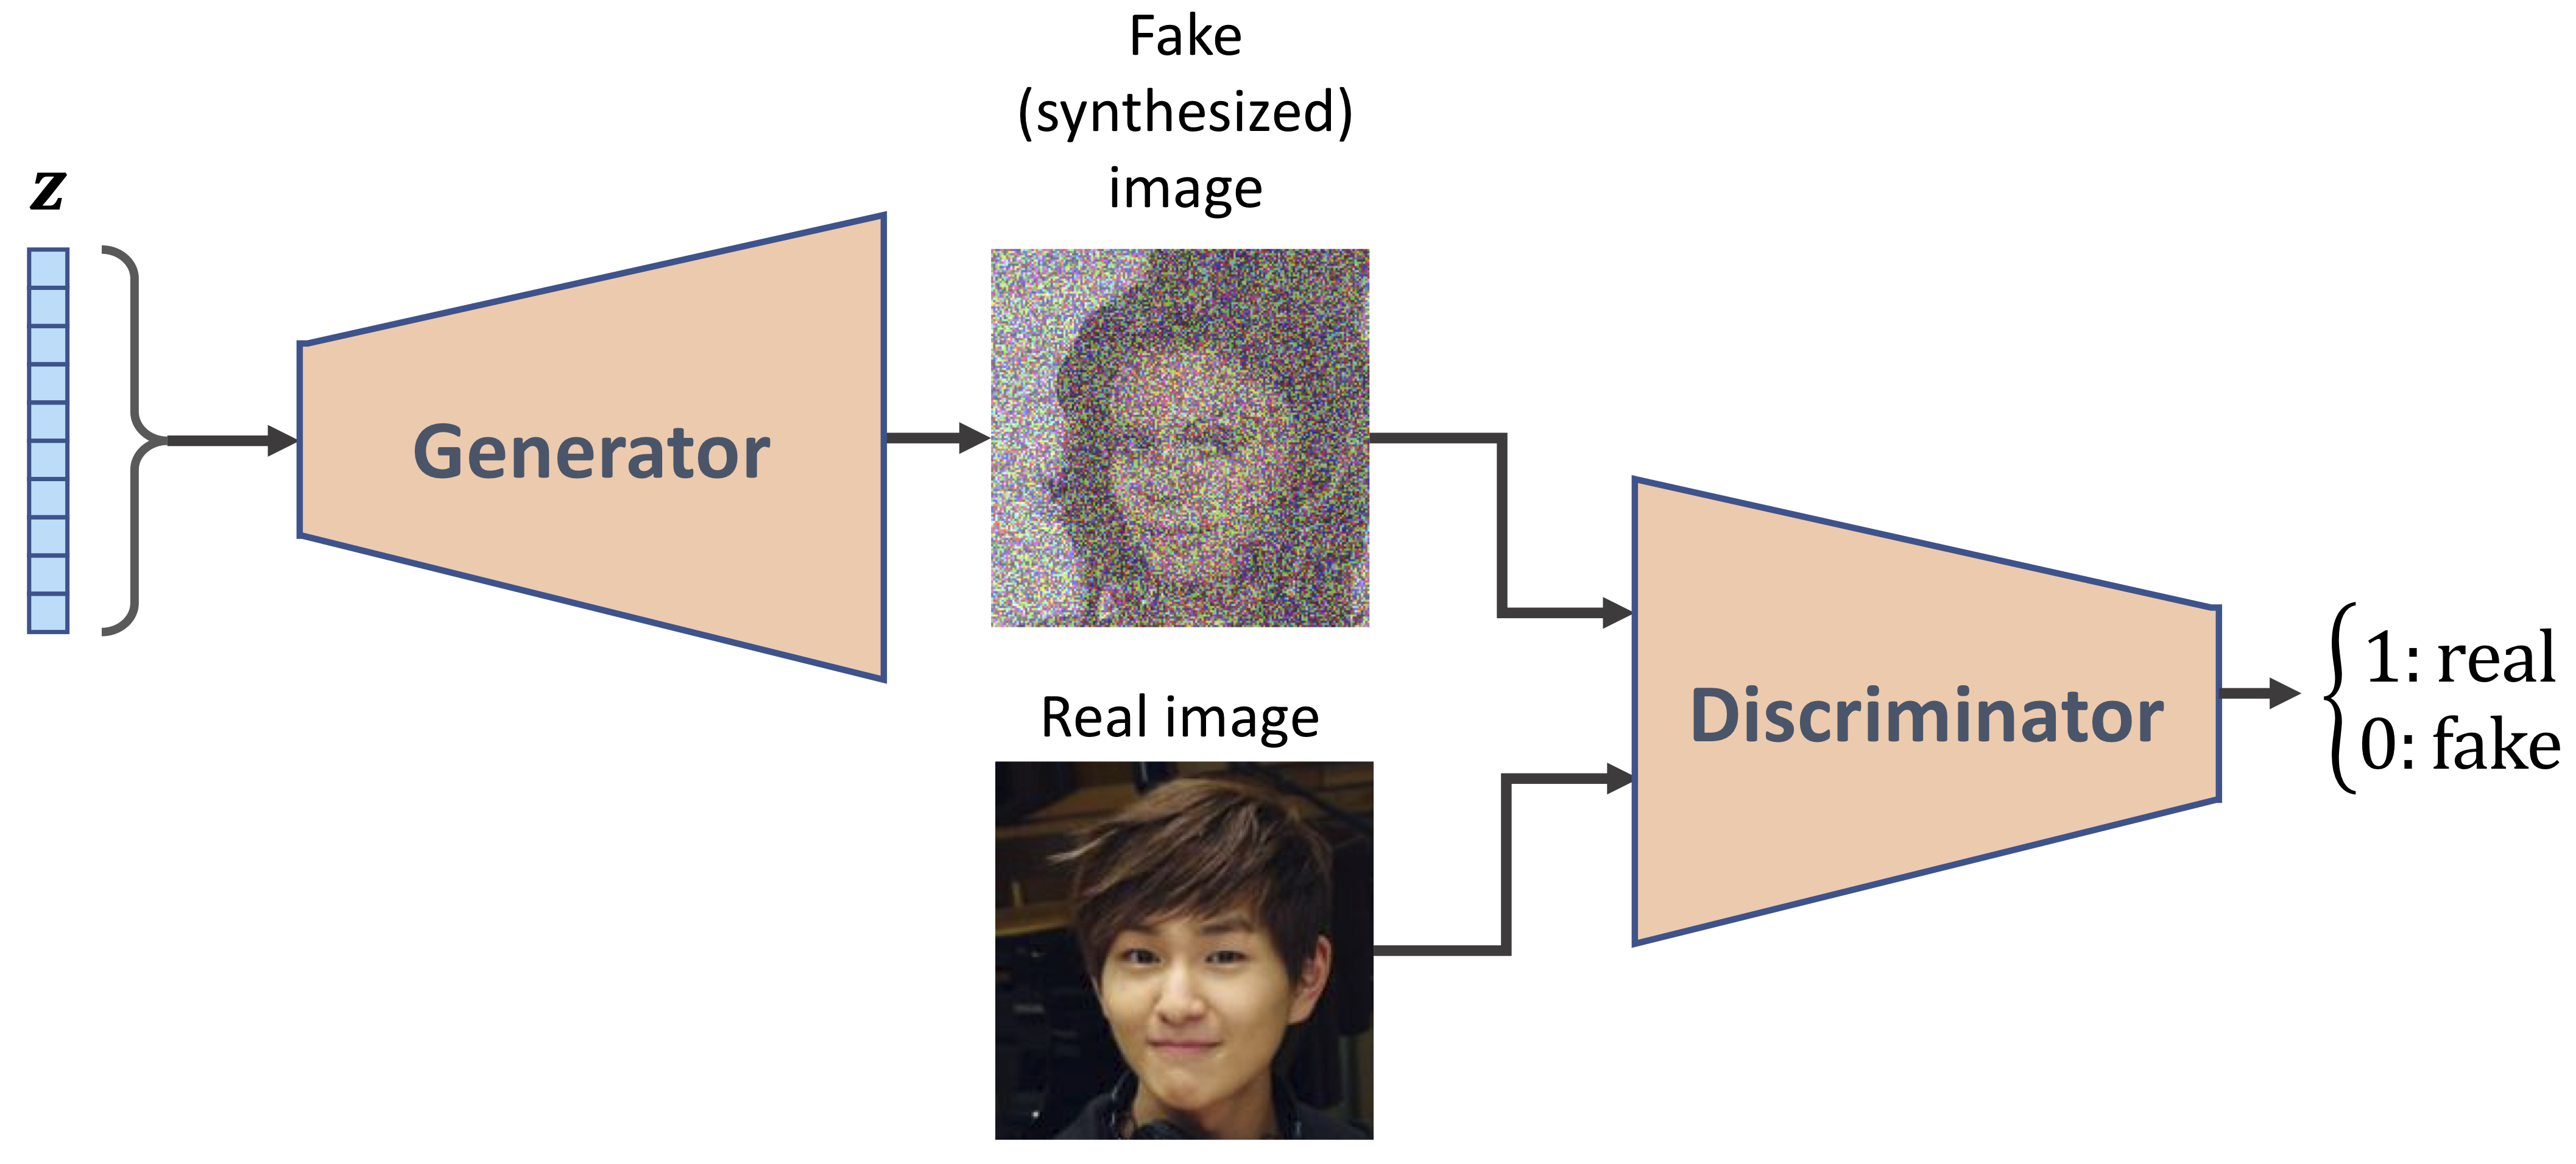

In [2]:
Image(filename='figures/17_03.png', width=700)

#### Loss functions for generator and discriminator

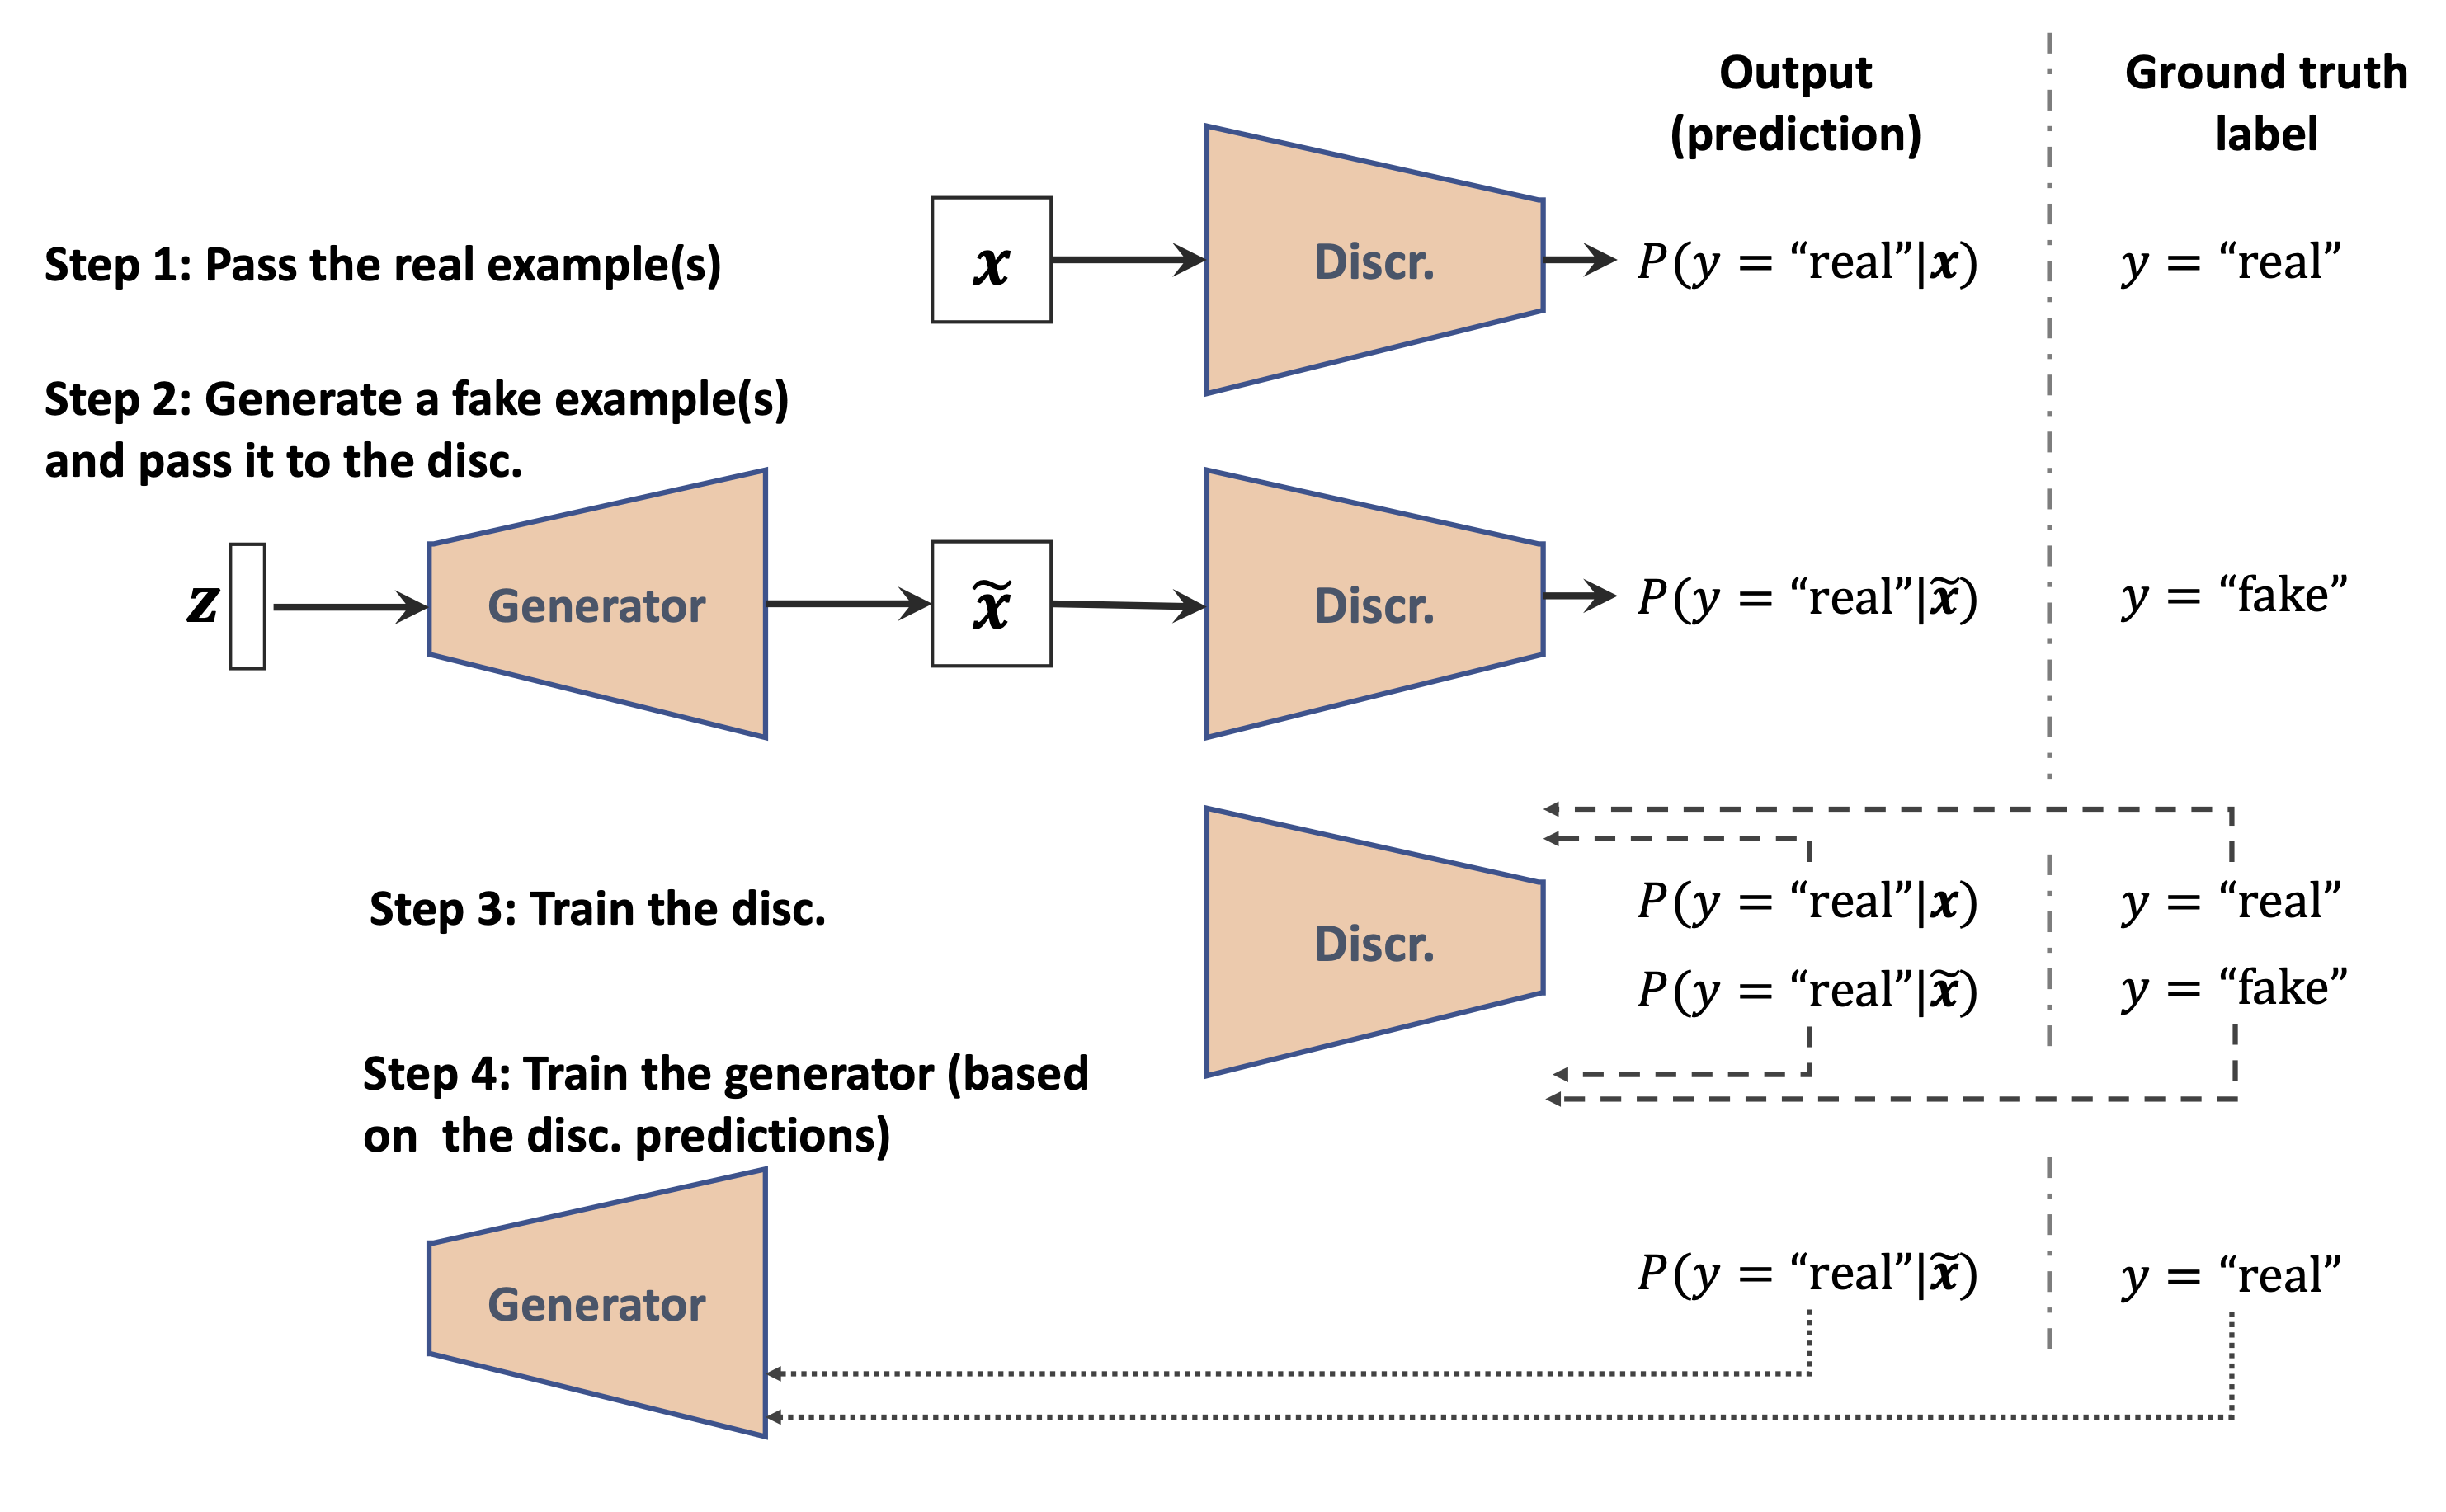

In [3]:
Image(filename='figures/17_04.png', width=800)

### Implement a Simple GANs from scratch
* we start with a simple implementation of GANs
  + generator consists of a single hidden layer using a 20 dimensional normal distribution input, a 100 unit hidden layer, and a fully connected linear layer of 784 units, with a Tanh transformation. The output units are reshape to form a 28 by 28 image.
  + discriminator accepts a 784 dimension tensor (reshaped from 28 by 28 input image), with a fully connected linear hidden layer of 100 units, with leaky-ReLU transformation, and then another fully connected Linear layer with 1 single unit, and a sigmoid transformation as a binary classifier

#### The architectures of generator and discriminator are shown below:

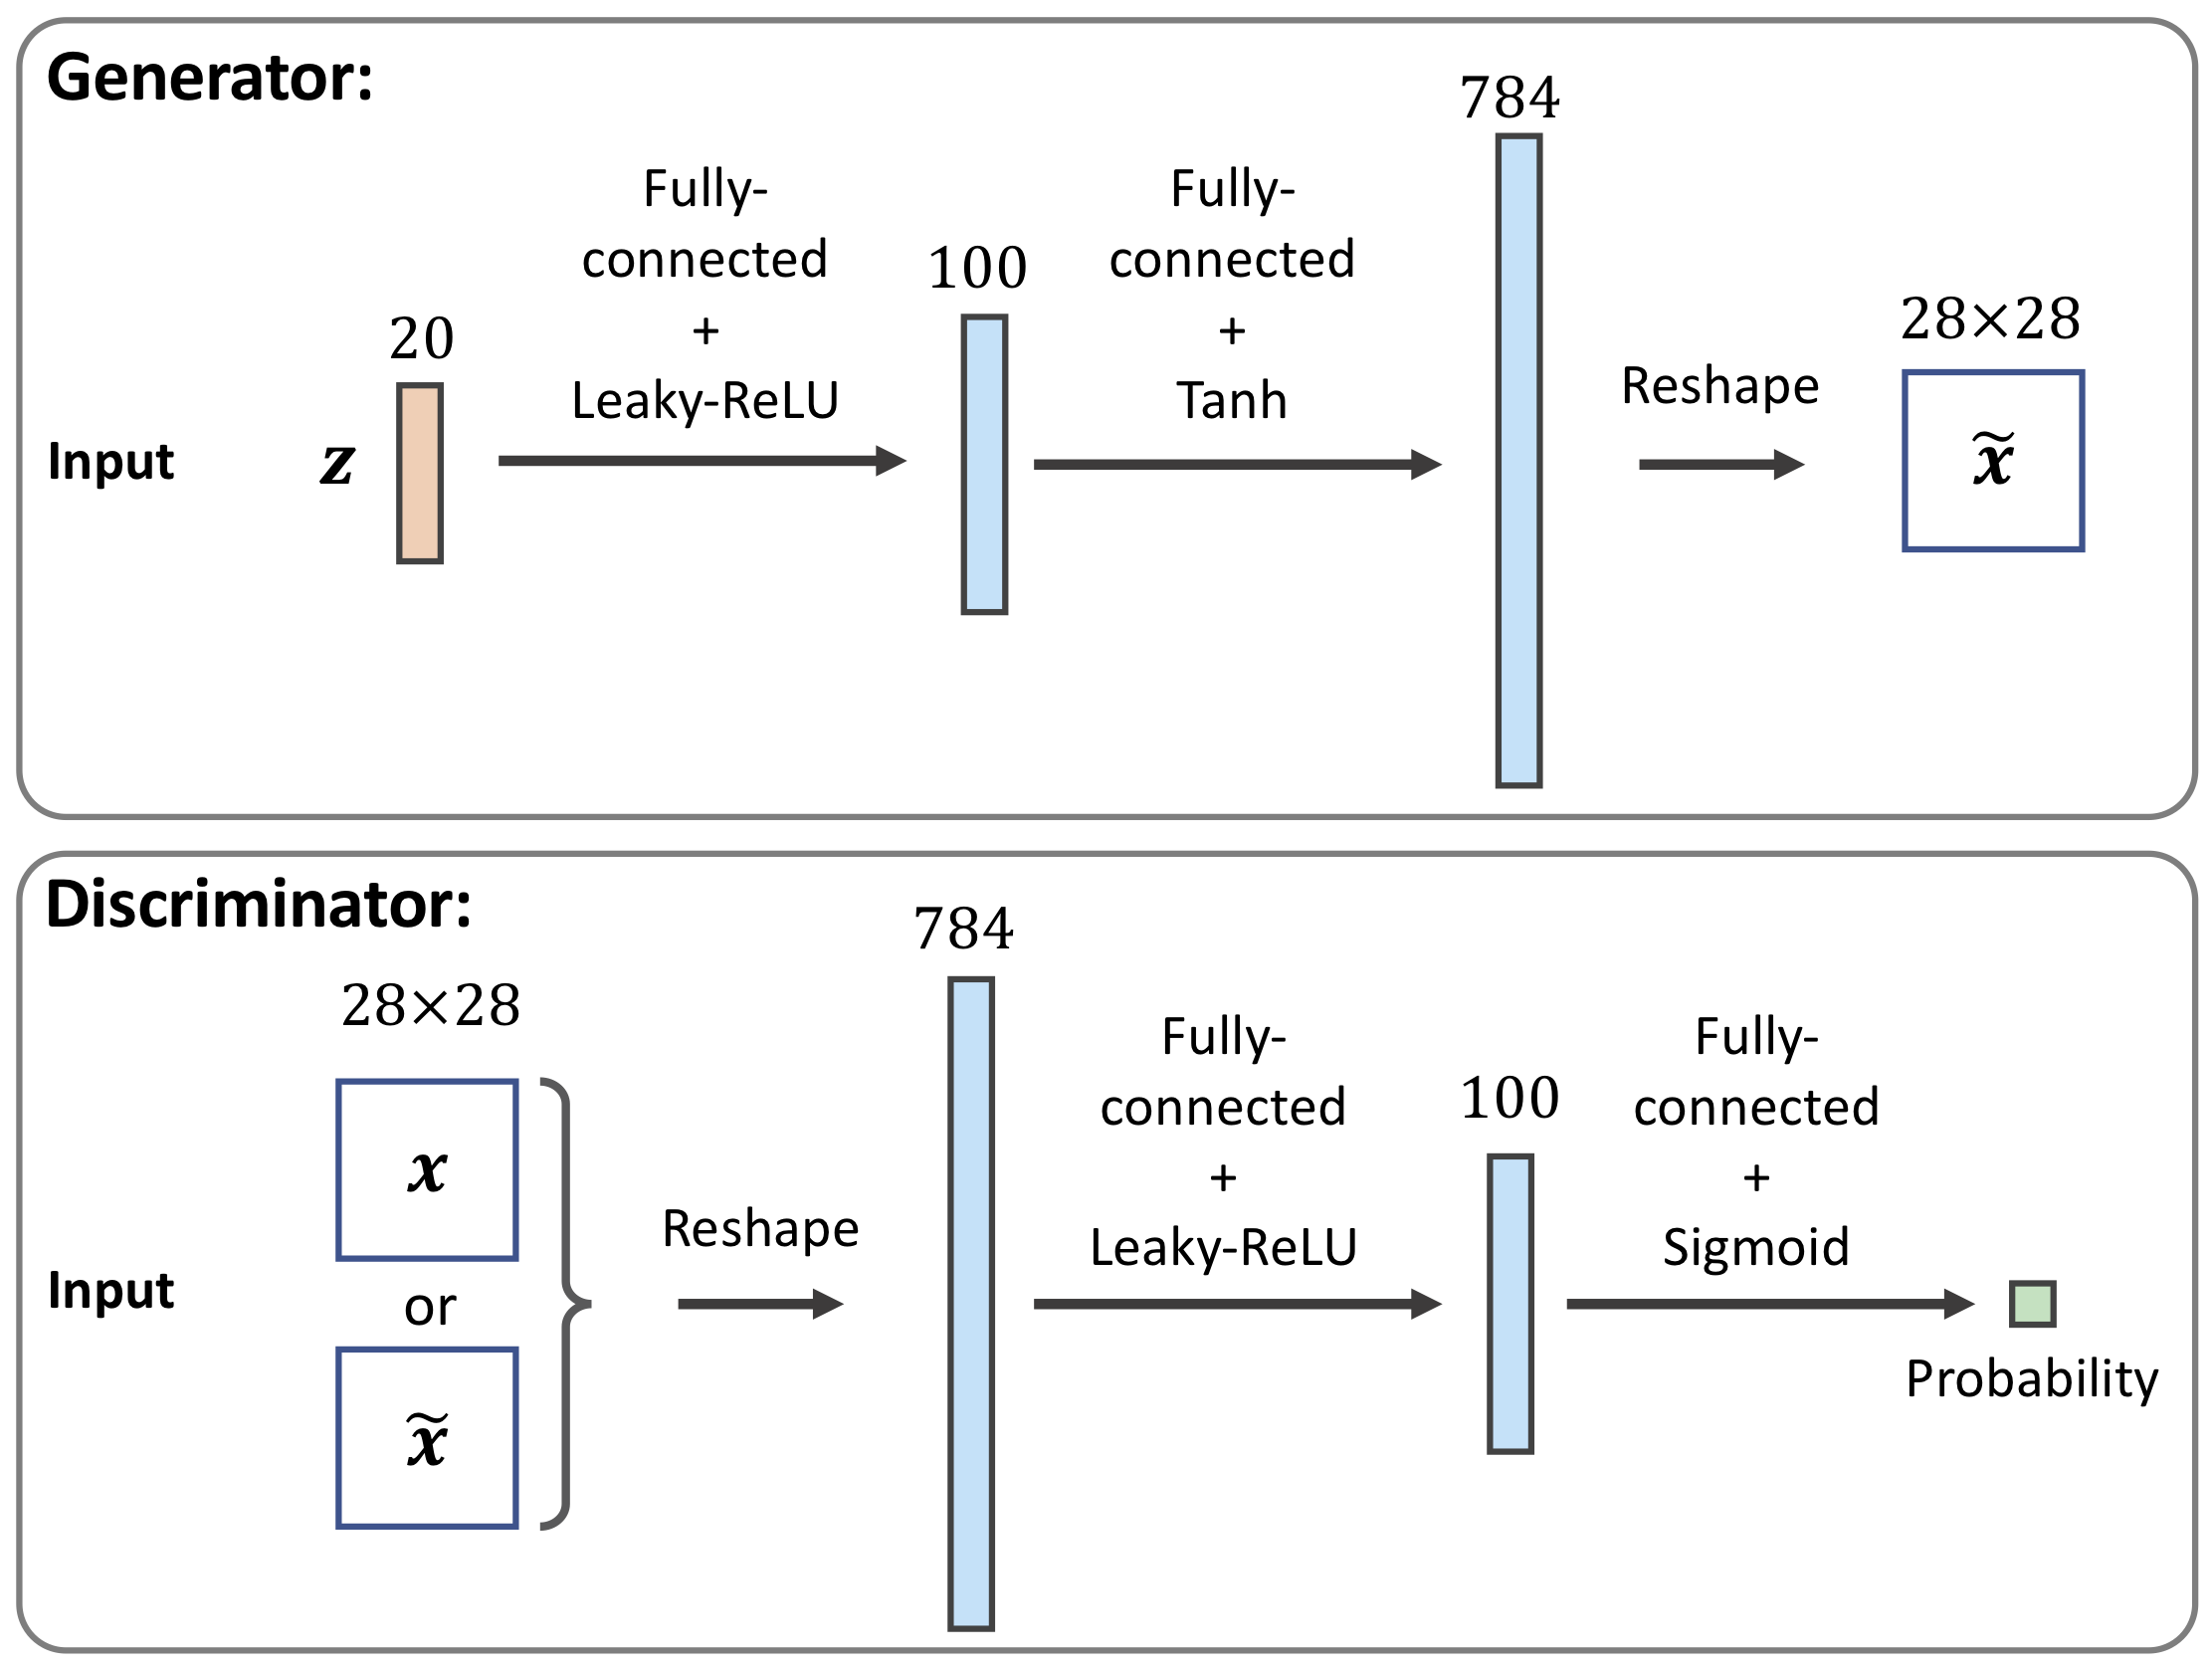

In [4]:
Image(filename='figures/17_08.png', width=600)

In [5]:
import torch.nn as nn
import matplotlib.pyplot as plt

#### Build generator

In [8]:
def make_generator(input_size, num_layers, hidden_size, output_size):
    all_layers = []

    input_size = input_size
    for i in range(num_layers):
        all_layers.append(nn.Linear(input_size, hidden_size))
        all_layers.append(nn.LeakyReLU())
        input_size = hidden_size
    all_layers.append(nn.Linear(hidden_size, output_size))
    all_layers.append(nn.Tanh())

    return nn.Sequential(*all_layers)

input_size = 20
num_layers = 1
hidden_size = 100
output_size = 784

generator = make_generator(input_size, num_layers, hidden_size, output_size)
generator


Sequential(
  (0): Linear(in_features=20, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=100, out_features=784, bias=True)
  (3): Tanh()
)

#### Build Discriminator

In [13]:
def make_discriminator(image_size, num_layers, hidden_size):
    all_layers = []

    input_size = image_size

    for i in range(num_layers):
        all_layers.append(nn.Linear(input_size, hidden_size, bias=False))
        all_layers.append(nn.LeakyReLU())
        all_layers.append(nn.Dropout(p=0.5))
        
    all_layers.append(nn.Linear(hidden_size, 1))
    all_layers.append(nn.Sigmoid())

    return nn.Sequential(*all_layers)

In [14]:
image_size = 28 * 28
num_layers = 1
hidden_size = 100
disc_model = make_discriminator(image_size, num_layers, hidden_size)
disc_model

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=False)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=100, out_features=1, bias=True)
  (4): Sigmoid()
)

### Prepare training data
* we use MNIST dataset for training dataset

In [19]:
import torchvision 
from torchvision import transforms 
from torch.utils.data import DataLoader

image_path = "data/"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, download=False, transform=transform)

example, label = next(iter(mnist_dataset))

print(f'Min: {example.min()} Max: {example.max()}')
print(example.shape)


Min: -1.0 Max: 1.0
torch.Size([1, 28, 28])


In [20]:
batch_size = 32
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True) 

In [18]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1 
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

#### check dimensions of generator and disc_model

In [28]:
input_real, label = next(iter(mnist_dl))
# since the disc_model accepts 784 dimension input, we need to reshape input to (32, 784)
input_real = input_real.view(batch_size, -1)
print(f"input_real shape: {input_real.shape}")

torch.manual_seed(1)
z_size = 20

# generate uniform noise for generator
mode_z = "uniform"
input_z = create_noise(batch_size, z_size, mode_z)
print(f"input_z shape {input_z.shape}")

# generate a batch of images
input_fake = generator(input_z)
print(f"generated image shape: {input_fake.shape}")

# discriminate real and fake batch images
d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(input_fake)
print('Disc. (real) -- shape:', d_proba_real.shape)
print('Disc. (fake) -- shape:', d_proba_fake.shape)

input_real shape: torch.Size([32, 784])
input_z shape torch.Size([32, 20])
generated image shape: torch.Size([32, 784])
Disc. (real) -- shape: torch.Size([32, 1])
Disc. (fake) -- shape: torch.Size([32, 1])


### Model Training
#### General concept
* for generator, we train generator model using the generated image and set the d_generator as ones
  + d_generator is the probability by discriminator for generated images. We want these probability to be as close to 1 as possible
  + this means the images generated by generator can "cheat" the discriminator
* for disc_model, we want d_proba_real to be close to 1 and d_proba_fake to be close to 0

In [30]:
loss_fn = nn.BCELoss()

g_proba_labels = torch.ones_like(d_proba_fake)
loss_g = loss_fn(d_proba_fake, g_proba_labels)
print(f"disc_model loss: {loss_g:.4f}")

d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

print(f"d_loss_real: {d_loss_real:.4f}")
print(f"d_loss_fake: {d_loss_fake:.4f}")

disc_model loss: 0.7084
d_loss_real: 0.7264
d_loss_fake: 0.6784


#### set up generator and discriminator models

In [32]:
loss_fn = nn.BCELoss()
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 
batch_size = 64
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, 
                      shuffle=True, drop_last=True)

image_size = 28 * 28
z_size = 20
g_num_layers = 1
g_hidden_size = 100
g_output_size = 784

g_model = make_generator(z_size, g_num_layers, g_hidden_size, image_size).to(device)


d_num_layers = 1
d_hidden_size = 100
d_model = make_discriminator(image_size, d_num_layers, d_hidden_size).to(device)

g_optimizer = torch.optim.Adam(g_model.parameters(), lr=0.001)
d_optimizer = torch.optim.Adam(d_model.parameters(), lr=0.001)

#### define training procedure for discriminator and test

In [52]:
def d_train(real_x, z_size, z_mode):
    d_optimizer.zero_grad()

    batch_size = real_x.shape[0]
    real_x = real_x.view(batch_size, -1).to(device)
    real_preds = d_model(real_x)
    real_labels = torch.ones_like(real_preds, device=device)
    real_loss = loss_fn(real_preds, real_labels)

    input_z = create_noise(real_x.shape[0], z_size, z_mode).to(device)
    fake_imgs = g_model(input_z)
    fake_preds = d_model(fake_imgs)
    fake_labels = torch.zeros_like(fake_preds, device=device)
    fake_loss = loss_fn(fake_preds, fake_labels)

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item(), real_preds.detach(), fake_preds.detach()

In [53]:
# test d_train
input_real = input_real.to(device)
d_loss, real_probas, fake_probas = d_train(input_real, z_size, "uniform")
print(f"d_loss={d_loss}, real_probas.shape: {real_probas.shape}, fake_probas.shape:{real_probas.shape}")

d_loss=0.6656776070594788, real_probas.shape: torch.Size([32, 1]), fake_probas.shape:torch.Size([32, 1])


#### define training procedure for generator and test

In [54]:
def g_train(batch_size, z_size, z_mode):
    g_optimizer.zero_grad()

    input_z = create_noise(batch_size, z_size, z_mode).to(device)
    fake_imgs = g_model(input_z)
    fake_preds = d_model(fake_imgs)
    g_labels = torch.ones_like(fake_preds, device=device)
    
    g_loss = loss_fn(fake_preds, g_labels)
    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()    

In [55]:
# test g_train
batch_size = input_real.shape[0]
g_loss = g_train(batch_size, z_size, "uniform")
print(f"g_loss: {g_loss}")

g_loss: 0.766342282295227


#### define image generator function by generator model
* to show the image, we need to shif the tensors generated to be in the range of \[0, 1\]
* the images generated are in the range \[-1, 1\]. We transform them by plus one and divided by 2

In [65]:
def create_samples(g_model, input_z, image_size):
    imgs = g_model(input_z)
    batch_size = input_z.shape[0]
    
    imgs = imgs.reshape(batch_size, *image_size)
    return (imgs + 1) / 2

In [66]:
# test create_samples
image_size = (28, 28)
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
create_samples(g_model, fixed_z, image_size)


tensor([[[3.9935e-05, 1.7881e-05, 5.6819e-03,  ..., 2.0564e-06,
          4.9463e-04, 2.1011e-05],
         [1.1504e-05, 1.4361e-02, 2.6226e-06,  ..., 7.2420e-06,
          1.8775e-06, 3.6657e-06],
         [4.0233e-06, 4.2915e-06, 9.9838e-06,  ..., 2.8610e-06,
          1.0166e-04, 2.0593e-05],
         ...,
         [2.9802e-07, 7.0035e-06, 1.3411e-06,  ..., 1.0639e-05,
          5.0178e-04, 3.4273e-06],
         [4.5300e-06, 4.5896e-06, 1.0431e-06,  ..., 1.1325e-06,
          6.2287e-06, 4.2617e-06],
         [5.3346e-06, 3.3677e-06, 1.2517e-05,  ..., 2.6822e-06,
          2.2623e-04, 9.5069e-06]],

        [[1.6272e-05, 1.4782e-05, 5.1307e-01,  ..., 1.8775e-06,
          4.6821e-02, 3.9795e-04],
         [1.0669e-05, 9.3582e-01, 2.4170e-04,  ..., 1.3122e-04,
          1.5199e-05, 7.2807e-05],
         [8.0615e-05, 3.3081e-06, 2.0862e-05,  ..., 2.8312e-06,
          1.9251e-03, 1.8850e-04],
         ...,
         [9.7901e-05, 2.1458e-06, 2.1935e-05,  ..., 6.7887e-04,
          3.537

#### Define training procedure

In [68]:
import numpy as np
# generate a fixed uniform distribution data for generator
# this is used to compare quality of images generated by different generators
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

batch_size = 32
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True) 

# set up lists to collect loss, predict probabilities and generated samples
epoch_samples = []

all_d_losses = []
all_g_losses = []

all_d_real = []
all_d_fake = []

num_epochs = 100
torch.manual_seed(1)
z_size = 20
z_mode = "uniform"
image_size = (28, 28)

for epoch in range(num_epochs):
    for i, (x, _) in enumerate(mnist_dl):
        d_losses, g_losses = [], []
        d_proba_real, d_proba_fake = [], []
        d_loss, real_probas, fake_probas = d_train(x, z_size, z_mode)
        d_losses.append(d_loss)
        g_losses.append(g_train(x.shape[0], z_size, z_mode))
        d_proba_real.append(real_probas.mean().cpu())
        d_proba_fake.append(fake_probas.mean().cpu())

    all_d_losses.append(np.mean(d_losses))
    all_g_losses.append(np.mean(g_losses))
    all_d_real.append(np.mean(d_proba_real))
    all_d_fake.append(np.mean(d_proba_fake))
    epoch_samples.append(
        create_samples(g_model, fixed_z, image_size).detach().cpu().numpy())
    print(f"epoch:{epoch}, G/D loss: {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}, real/fake probas: {all_d_real[-1]:.4f}/{all_d_fake[-1]:.4f}")
        

epoch:0, G/D loss: 0.8722/1.3001, real/fake probas: 0.6120/0.4909
epoch:1, G/D loss: 0.8306/1.1423, real/fake probas: 0.6717/0.4569
epoch:2, G/D loss: 0.8071/1.3003, real/fake probas: 0.5676/0.4691
epoch:3, G/D loss: 0.9768/1.2902, real/fake probas: 0.5755/0.4695
epoch:4, G/D loss: 0.8745/1.2629, real/fake probas: 0.5942/0.4787
epoch:5, G/D loss: 0.8668/1.2278, real/fake probas: 0.5585/0.4358
epoch:6, G/D loss: 0.8643/1.2536, real/fake probas: 0.5359/0.4200
epoch:7, G/D loss: 0.8646/1.1819, real/fake probas: 0.5989/0.4411
epoch:8, G/D loss: 0.9947/1.3718, real/fake probas: 0.5099/0.4679
epoch:9, G/D loss: 0.9097/1.1997, real/fake probas: 0.5711/0.4386
epoch:10, G/D loss: 0.9285/1.2892, real/fake probas: 0.5395/0.4429
epoch:11, G/D loss: 0.7863/1.3298, real/fake probas: 0.5346/0.4828
epoch:12, G/D loss: 0.7575/1.3998, real/fake probas: 0.4845/0.4772
epoch:13, G/D loss: 0.7629/1.3881, real/fake probas: 0.5093/0.4916
epoch:14, G/D loss: 0.7311/1.3806, real/fake probas: 0.5121/0.4864
epoch

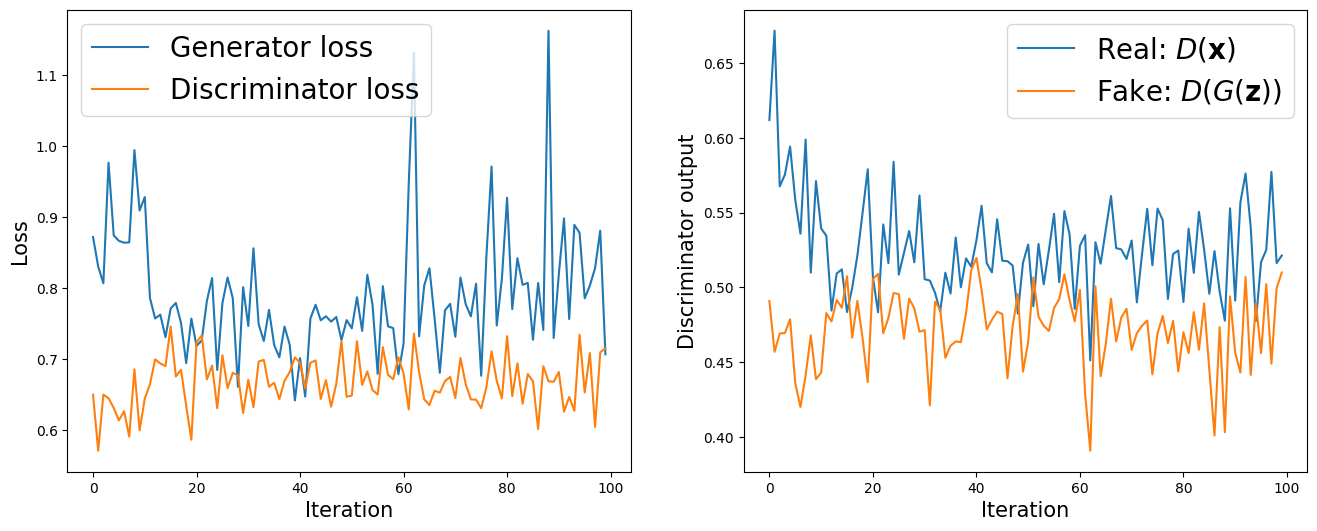

In [69]:
import itertools


fig = plt.figure(figsize=(16, 6))

## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
 
plt.plot(all_g_losses, label='Generator loss')
half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(half_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

#plt.savefig('figures/ch17-gan-learning-curve.pdf')
plt.show()

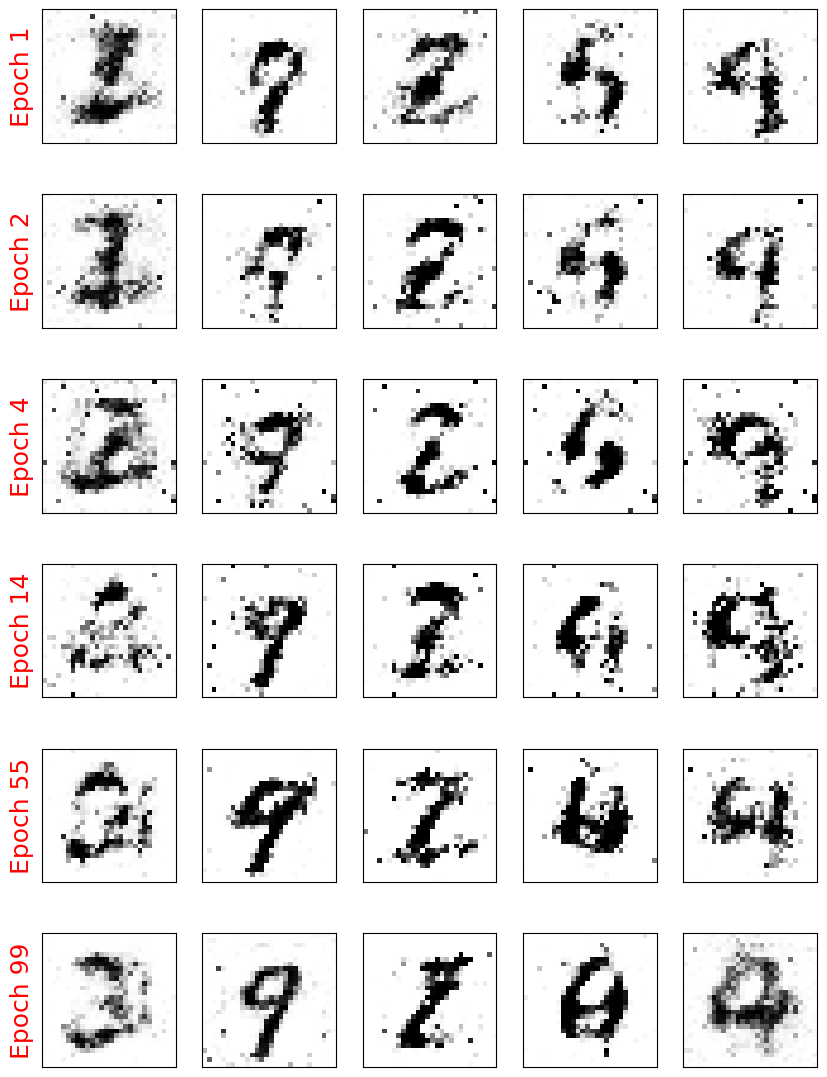

In [70]:
selected_epochs = [1, 2, 4, 14, 55, 99]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

### Evaluate similarity between real and generated images

In [71]:
import math

def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX,-1).cuda()
    X2 = (X*X).sum(1).resize_(nX,1)
    Y = Y.view(nY,-1).cuda()
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX,nY) + Y2.expand(nY,nX).transpose(0,1) - 2*torch.mm(X,Y.transpose(0,1)))

    del X, X2, Y, Y2
    
    if sqrt:
        M = ((M+M.abs())/2).sqrt()
    
    return M

In [72]:
def mmd(Mxx, Mxy, Myy, sigma) :
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx/(scale*2*sigma*sigma))
    Mxy = torch.exp(-Mxy/(scale*2*sigma*sigma))
    Myy = torch.exp(-Myy/(scale*2*sigma*sigma))
    a = Mxx.mean()+Myy.mean()-2*Mxy.mean()
    mmd = math.sqrt(max(a, 0))

    return mmd

In [73]:
def compute_score(fake, real , k=1, sigma=1, sqrt=True):

    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

 
    print(mmd(Mxx, Mxy, Myy, sigma))

In [74]:
whole_dl = DataLoader(mnist_dataset, batch_size=10000, 
                      shuffle=True, drop_last=True) 

In [75]:
real_image = next(iter(whole_dl))[0]

In [76]:
compute_score(torch.from_numpy(epoch_samples[-1]), real_image)

0.8990447272863442
